Importing the necessary libraries

In [1]:
import os
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_hub as hub
import keras
from keras import Model
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Reshape, LSTM
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.applications import MobileNetV2

Importing and analyzing the dataset

In [2]:
data_dir='/kaggle/input/satellite-image-classification/data'
classes=os.listdir(data_dir)
for root,dirs,imgs in os.walk(data_dir):
    print(len(root),len(dirs),len(imgs))

49 4 0
56 0 1500
56 0 1131
60 0 1500
55 0 1500


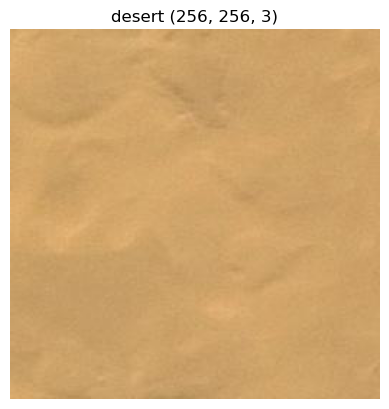

array([[[207, 163, 102],
        [205, 161, 100],
        [203, 159,  98],
        ...,
        [209, 164, 107],
        [209, 164, 107],
        [208, 163, 106]],

       [[208, 164, 103],
        [206, 162, 101],
        [206, 162, 101],
        ...,
        [208, 163, 106],
        [207, 162, 105],
        [205, 160, 103]],

       [[210, 166, 105],
        [209, 165, 104],
        [209, 165, 104],
        ...,
        [210, 165, 108],
        [208, 163, 106],
        [206, 161, 104]],

       ...,

       [[220, 174, 112],
        [219, 173, 111],
        [217, 171, 109],
        ...,
        [203, 160, 105],
        [204, 161, 106],
        [204, 161, 106]],

       [[221, 173, 111],
        [220, 172, 110],
        [218, 170, 108],
        ...,
        [203, 160, 105],
        [203, 160, 105],
        [202, 159, 104]],

       [[217, 169, 107],
        [215, 167, 105],
        [214, 166, 104],
        ...,
        [201, 158, 103],
        [199, 156, 101],
        [197, 154,  99]]

In [3]:
#Function to show random image samples from dataset
def random_sample(img_class='all'):
    if img_class=='all':
        class_name=random.choice(classes)
        class_dir=os.path.join(data_dir,class_name)
        imgs=os.listdir(class_dir)
        rndm_img_name=random.choice(imgs)
        img_path=os.path.join(class_dir,rndm_img_name)
        img=plt.imread(img_path)
    elif img_class in classes:
        class_name=img_class
        class_dir=os.path.join(data_dir,class_name)
        imgs=os.listdir(class_dir)
        rndm_img_name=random.choice(imgs)
        img_path=os.path.join(class_dir,rndm_img_name)
        img=plt.imread(img_path)
    else:
        print("Please choose an appropriate value as image class.")
    plt.imshow(img)
    plt.title(f"{class_name} {img.shape}")
    plt.axis(False)
    plt.show()
    return img

#A sample image
random_sample(img_class='desert')
        

In [4]:
#Determining the number of images in each class
for c in classes:
    class_dir=os.path.join(data_dir,c)
    imgs=os.listdir(class_dir)
    print(f"There are {len(imgs)} images in {c} class.")

There are 1500 images in cloudy class.
There are 1131 images in desert class.
There are 1500 images in green_area class.
There are 1500 images in water class.


Splitting the dataset

In [5]:
!pip install split-folders
import splitfolders

In [6]:
#Creating train, test and validation sets
splitfolders.ratio(data_dir,output='output')

Copying files: 5631 files [00:45, 122.46 files/s]


Data Preprocessing

In [7]:
#Creating data generators for train, test and validation datasets
train_datagen=ImageDataGenerator(rescale=1./255, zoom_range=0.2, shear_range=0.1, horizontal_flip=True)
val_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

#Creating train, test and validation datasets
train=train_datagen.flow_from_directory('/kaggle/working/output/train', target_size=(256,256), batch_size=32, class_mode='categorical', seed=42)
val=val_datagen.flow_from_directory('/kaggle/working/output/val', target_size=(256,256), batch_size=32, class_mode='categorical', seed=42)
test=test_datagen.flow_from_directory('/kaggle/working/output/test', target_size=(256,256), batch_size=32, class_mode='categorical', seed=42)

Found 4504 images belonging to 4 classes.
Found 563 images belonging to 4 classes.
Found 564 images belonging to 4 classes.


Model Training

1. Custom CNN Model (Baseline Model)

In [8]:
#Creating the CNN Model
model=Sequential()
size=(256,256,3)
model.add(Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=size))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

#Compiling the model
model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

#Training the model
base_model=model.fit(train, epochs=10, steps_per_epoch=len(train), validation_data=val, validation_steps=len(val))


Epoch 1/10
141/141 [==============================] - 77s 459ms/step - loss: 0.5558 - accuracy: 0.7387 - val_loss: 0.4250 - val_accuracy: 0.7851
Epoch 2/10
141/141 [==============================] - 64s 453ms/step - loss: 0.3896 - accuracy: 0.8348 - val_loss: 0.3340 - val_accuracy: 0.8650
Epoch 3/10
141/141 [==============================] - 65s 458ms/step - loss: 0.3627 - accuracy: 0.8541 - val_loss: 0.3074 - val_accuracy: 0.8845
Epoch 4/10
141/141 [==============================] - 65s 460ms/step - loss: 0.3398 - accuracy: 0.8641 - val_loss: 0.3970 - val_accuracy: 0.8526
Epoch 5/10
141/141 [==============================] - 66s 468ms/step - loss: 0.3377 - accuracy: 0.8652 - val_loss: 0.3697 - val_accuracy: 0.8472
Epoch 6/10
141/141 [==============================] - 65s 464ms/step - loss: 0.3205 - accuracy: 0.8692 - val_loss: 0.3594 - val_accuracy: 0.8757
Epoch 7/10
141/141 [==============================] - 65s 457ms/step - loss: 0.3471 - accuracy: 0.8561 - val_loss: 0.3044 - val_ac

In [9]:
#Evaluating the CNN model on test dataset
cnn_loss,cnn_acc=model.evaluate(test)
print("Accuracy of CNN Model: ",cnn_acc)
print("Loss of CNN Model: ",cnn_loss)

18/18 [==============================] - 2s 87ms/step - loss: 0.2790 - accuracy: 0.8883
Accuracy of CNN Model:  0.8882978558540344
Loss of CNN Model:  0.2790334224700928


Visualizing the Baseline CNN Model

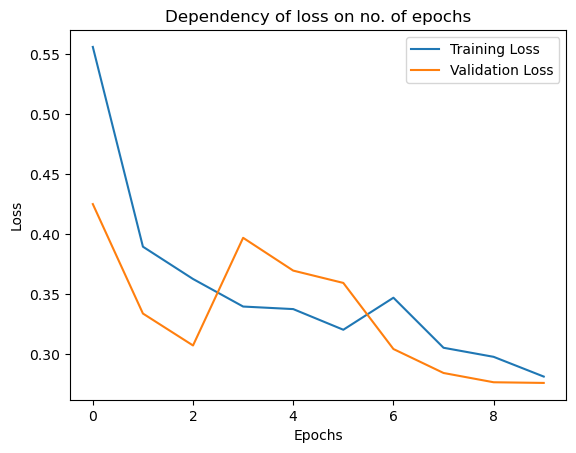

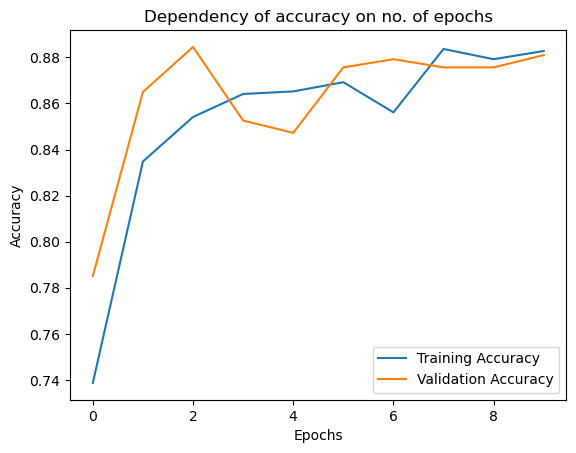

In [10]:
def plot_curve(hist):
    loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    accuracy=hist.history['accuracy']
    val_accuracy=hist.history['val_accuracy']
    epochs=range(len(hist.history['loss']))
    
    #Plot loss
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Dependency of loss on no. of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print('\n\n')
    
    #Plot accuracy
    plt.plot(epochs, accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Dependency of accuracy on no. of epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    
#Passing the CNN model to the function
plot_curve(base_model)

2. MobileNet V2 Feature Vector (Transfer Learning)

In [11]:
#ImageNet V2 Feature Vector (Version 4)
mobilenet_url='https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

#Create data for ImageNet model
mobilenet_train=train_datagen.flow_from_directory('/kaggle/working/output/train', target_size=(224,224), batch_size=32, class_mode='categorical', seed=42)
mobilenet_val=val_datagen.flow_from_directory('/kaggle/working/output/val', target_size=(224,224), batch_size=32, class_mode='categorical', seed=42)
mobilenet_test=test_datagen.flow_from_directory('/kaggle/working/output/test', target_size=(224,224), batch_size=32, class_mode='categorical', seed=42)


Found 4504 images belonging to 4 classes.
Found 563 images belonging to 4 classes.
Found 564 images belonging to 4 classes.


MobileNet model with Sequential API

In [12]:
#Installing the pretrained ImageNet model and saving it as a keras Layer (Sequential API)
feature_vector_layer=hub.KerasLayer(mobilenet_url, trainable=False, input_shape=(224,224,3))
mobilenet_model=Sequential([feature_vector_layer, Dense(100, activation='relu'), Dense(4, activation='softmax')])

#Compiling the model
mobilenet_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])

#Training the model
mobilenet_hist=mobilenet_model.fit(mobilenet_train, epochs=10, steps_per_epoch=len(mobilenet_train), validation_data=mobilenet_val, validation_steps=len(mobilenet_val))

Epoch 1/10
141/141 [==============================] - 57s 380ms/step - loss: 0.1294 - accuracy: 0.9609 - val_loss: 0.0943 - val_accuracy: 0.9716
Epoch 2/10
141/141 [==============================] - 52s 369ms/step - loss: 0.0464 - accuracy: 0.9862 - val_loss: 0.0698 - val_accuracy: 0.9805
Epoch 3/10
141/141 [==============================] - 53s 378ms/step - loss: 0.0300 - accuracy: 0.9907 - val_loss: 0.1294 - val_accuracy: 0.9574
Epoch 4/10
141/141 [==============================] - 54s 380ms/step - loss: 0.0291 - accuracy: 0.9891 - val_loss: 0.0926 - val_accuracy: 0.9822
Epoch 5/10
141/141 [==============================] - 52s 370ms/step - loss: 0.0201 - accuracy: 0.9931 - val_loss: 0.0817 - val_accuracy: 0.9751
Epoch 6/10
141/141 [==============================] - 53s 380ms/step - loss: 0.0199 - accuracy: 0.9931 - val_loss: 0.0883 - val_accuracy: 0.9698
Epoch 7/10
141/141 [==============================] - 53s 376ms/step - loss: 0.0200 - accuracy: 0.9925 - val_loss: 0.0402 - val_ac

Visualizing MobileNet model with Sequential API

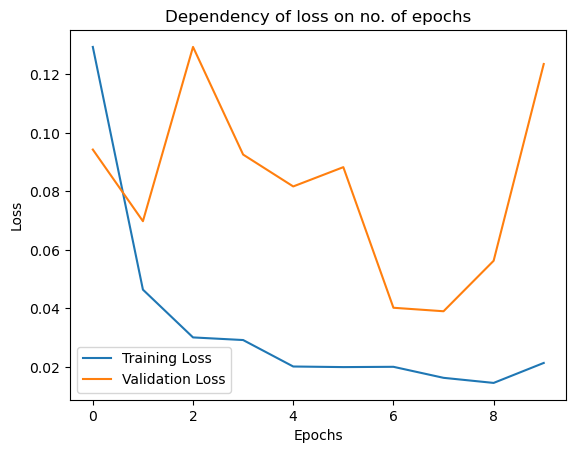

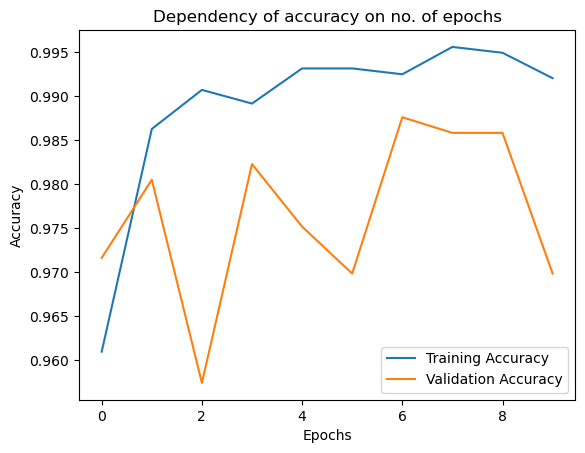

In [13]:
#Plot ImageNet loss and accuracy curves
plot_curve(mobilenet_hist)

Here, the training accuracy exceeds the validation accuracy. Hence, overfitting occurs. It can be minimized by using the model with functional API and then, fine tuning the model.

MobileNet Model with Functional API

In [14]:
#Create MobileNet model with Functional API
mobilenet=MobileNetV2(include_top=False)

#Freezing the bottom layers
mobilenet.trainable=False
inputs=Input(shape=(224,224,3), name='input_layer')
x=mobilenet(inputs)
print(f"Shape after mobilenet CNN Model: {x.shape}")
x=GlobalAveragePooling2D(name='global_average_pool_layer')(x)
print(f"Shape after GlobalAveragePooling Layer: {x.shape}")
x=Dense(100, activation='relu', name='dense_layer_100')(x)
outputs=Dense(4, activation='softmax', name='outputs_layer')(x)

#ImageNet Model (Functional API)
mobilenet_model=Model(inputs,outputs)

#Compiling the model
mobilenet_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#Training the Functional MobileNet model
mobilenet_model_hist=mobilenet_model.fit(mobilenet_train, epochs=10, steps_per_epoch=len(mobilenet_train), validation_data=mobilenet_val, validation_steps=len(mobilenet_val))

9406464/9406464 [==============================] - 0s 0us/step
Shape after mobilenet CNN Model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling Layer: (None, 1280)
Epoch 1/10
141/141 [==============================] - 57s 387ms/step - loss: 0.2699 - accuracy: 0.9110 - val_loss: 0.1220 - val_accuracy: 0.9645
Epoch 2/10
141/141 [==============================] - 53s 376ms/step - loss: 0.0843 - accuracy: 0.9767 - val_loss: 0.0975 - val_accuracy: 0.9716
Epoch 3/10
141/141 [==============================] - 54s 382ms/step - loss: 0.0606 - accuracy: 0.9820 - val_loss: 0.1094 - val_accuracy: 0.9716
Epoch 4/10
141/141 [==============================] - 54s 382ms/step - loss: 0.0475 - accuracy: 0.9865 - val_loss: 0.1207 - val_accuracy: 0.9556
Epoch 5/10
141/141 [==============================] - 55s 387ms/step - loss: 0.0418 - accuracy: 0.9882 - val_loss: 0.1011 - val_accuracy: 0.9734
Epoch 6/10
141/141 [==============================] - 54s 380ms/step - loss: 0.0396 - accuracy: 0.9876 - va

Visualizing Functional MobileNet Model

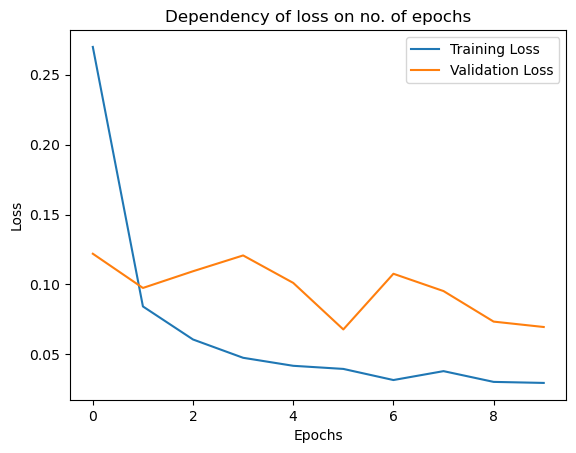

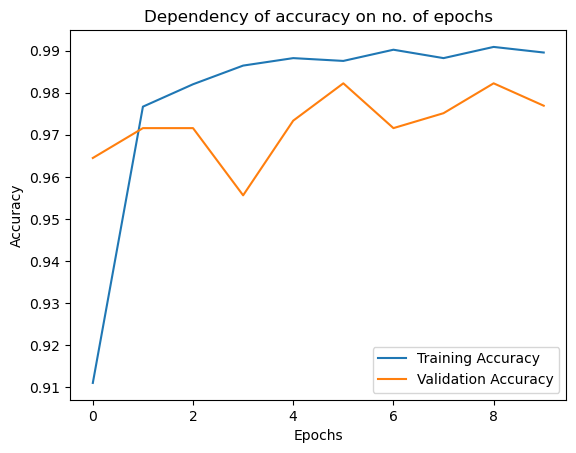

In [15]:
#Plot loss and accuracy
plot_curve(mobilenet_model_hist)

Now, to solve the problem of overfitting, the MobileNet model is finetuned.

Finetuning the MobileNet Model

In [16]:
for layer in mobilenet_model.layers:
    print(f"{layer.name}, {layer.trainable}")

input_layer, True
mobilenetv2_1.00_224, False
global_average_pool_layer, True
dense_layer_100, True
outputs_layer, True


In [17]:
#Checking out layers of ImageNetV2 model
for layer_name in mobilenet_model.layers[1].layers:
    print(f"{layer_name.name}: {layer_name.trainable}")

input_1: False
Conv1: False
bn_Conv1: False
Conv1_relu: False
expanded_conv_depthwise: False
expanded_conv_depthwise_BN: False
expanded_conv_depthwise_relu: False
expanded_conv_project: False
expanded_conv_project_BN: False
block_1_expand: False
block_1_expand_BN: False
block_1_expand_relu: False
block_1_pad: False
block_1_depthwise: False
block_1_depthwise_BN: False
block_1_depthwise_relu: False
block_1_project: False
block_1_project_BN: False
block_2_expand: False
block_2_expand_BN: False
block_2_expand_relu: False
block_2_depthwise: False
block_2_depthwise_BN: False
block_2_depthwise_relu: False
block_2_project: False
block_2_project_BN: False
block_2_add: False
block_3_expand: False
block_3_expand_BN: False
block_3_expand_relu: False
block_3_pad: False
block_3_depthwise: False
block_3_depthwise_BN: False
block_3_depthwise_relu: False
block_3_project: False
block_3_project_BN: False
block_4_expand: False
block_4_expand_BN: False
block_4_expand_relu: False
block_4_depthwise: False
bl

Since the model's layers were frozen, they are not trainable. To finetune the model, the **top layer** needs to be unfreezed.

In [18]:
mobilenet.trainable=True

#Freezing all layers except the last 10
for layer in mobilenet.layers[:-1]:
    layer.trainable=False
    
#Recompiling the model to incorporate changes
mobilenet_model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#Training the finetuned model
fine_tuned_model=mobilenet_model.fit(mobilenet_train, epochs=15, steps_per_epoch=len(mobilenet_train), validation_data=mobilenet_val, validation_steps=len(mobilenet_val), initial_epoch=mobilenet_model_hist.epoch[-1] )#Starting from a previous last epoch

Epoch 10/15
141/141 [==============================] - 57s 385ms/step - loss: 0.0321 - accuracy: 0.9867 - val_loss: 0.0719 - val_accuracy: 0.9787
Epoch 11/15
141/141 [==============================] - 53s 379ms/step - loss: 0.0332 - accuracy: 0.9887 - val_loss: 0.0786 - val_accuracy: 0.9822
Epoch 12/15
141/141 [==============================] - 53s 373ms/step - loss: 0.0273 - accuracy: 0.9918 - val_loss: 0.0592 - val_accuracy: 0.9840
Epoch 13/15
141/141 [==============================] - 54s 380ms/step - loss: 0.0267 - accuracy: 0.9905 - val_loss: 0.0746 - val_accuracy: 0.9805
Epoch 14/15
141/141 [==============================] - 54s 379ms/step - loss: 0.0221 - accuracy: 0.9938 - val_loss: 0.0601 - val_accuracy: 0.9858
Epoch 15/15
141/141 [==============================] - 53s 375ms/step - loss: 0.0296 - accuracy: 0.9896 - val_loss: 0.0666 - val_accuracy: 0.9822


In [19]:
#Evaluating the finetuned model
mobilenet_loss,mobilenet_acc=mobilenet_model.evaluate(mobilenet_test)
print("Accuracy of MobileNet model: ",mobilenet_acc)
print("Loss of MobileNet model: ",mobilenet_loss)

18/18 [==============================] - 2s 80ms/step - loss: 0.0458 - accuracy: 0.9840
Accuracy of MobileNet model:  0.9840425252914429
Loss of MobileNet model:  0.04584383964538574


Visual Comparison of models before and after finetuning

Accuracy metric length:  10
Total accuracy metric length:  16
Total accuracies:  [0.910968005657196, 0.9766873717308044, 0.9820159673690796, 0.9864564538002014, 0.9882326722145081, 0.9875665903091431, 0.990230917930603, 0.9882326722145081, 0.990896999835968, 0.989564836025238, 0.9866784811019897, 0.9886767268180847, 0.9917851090431213, 0.9904529452323914, 0.9937832951545715, 0.989564836025238]





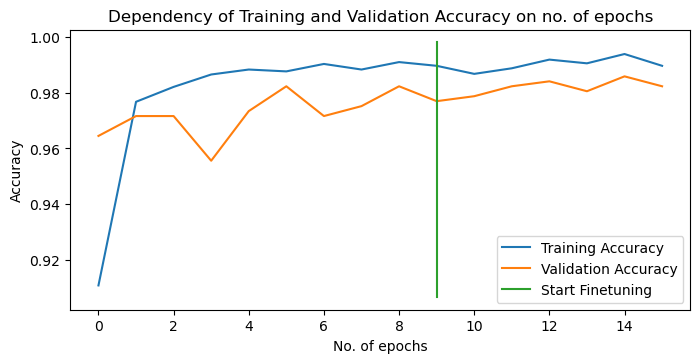

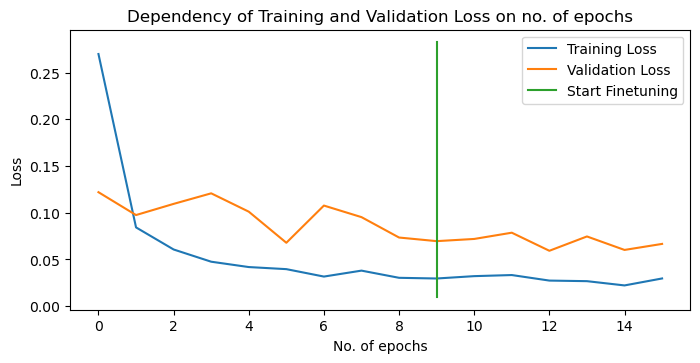

In [20]:
def compare_hist(original,new,initial_epochs=10):
    
    #Getting original history metrics
    acc=original.history['accuracy']
    loss=original.history['loss']
    print("Accuracy metric length: ",len(acc))
    val_acc=original.history['val_accuracy']
    val_loss=original.history['val_loss']
    
    #Combining original history with new history
    total_acc=acc+new.history['accuracy']
    total_loss=loss+new.history['loss']
    total_val_acc=val_acc+new.history['val_accuracy']
    total_val_loss=val_loss+new.history['val_loss']
    print("Total accuracy metric length: ",len(total_acc))
    print("Total accuracies: ",total_acc)
    print('\n\n')
    
    #Plotting accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Finetuning')
    plt.legend(loc='lower right')
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')
    plt.title('Dependency of Training and Validation Accuracy on no. of epochs')
    plt.show()
    print('\n\n')
    
    #Plotting loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1,initial_epochs-1], plt.ylim(), label='Start Finetuning')
    plt.legend(loc='upper right')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.title('Dependency of Training and Validation Loss on no. of epochs')
    plt.show()
    
#Comparing history by plot
compare_hist(mobilenet_model_hist,fine_tuned_model)

3. RNN Model

In [21]:
#Creating the RNN model
rnn_model=Sequential()
rnn_model.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(256,256,3)))
rnn_model.add(MaxPooling2D(pool_size=(2,2)))
rnn_model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
rnn_model.add(MaxPooling2D(pool_size=(2,2)))
rnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
rnn_model.add(MaxPooling2D(pool_size=(2,2)))
rnn_model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
rnn_model.add(MaxPooling2D(pool_size=(2,2)))
rnn_model.add(Flatten())
rnn_model.add(Reshape((-1,128)))
rnn_model.add(LSTM(128))
rnn_model.add(Dense(4, activation='softmax'))
              
#Compiling the model
rnn_model.compile(loss=CategoricalCrossentropy(), optimizer=Adam(), metrics=['accuracy'])
              
#Training the model
rnn_hist=rnn_model.fit(train, epochs=10, steps_per_epoch=len(train), validation_data=val, validation_steps=len(val))

Epoch 1/10
141/141 [==============================] - 69s 469ms/step - loss: 0.6979 - accuracy: 0.6175 - val_loss: 0.4911 - val_accuracy: 0.6874
Epoch 2/10
141/141 [==============================] - 67s 478ms/step - loss: 0.4689 - accuracy: 0.7722 - val_loss: 0.4843 - val_accuracy: 0.7425
Epoch 3/10
141/141 [==============================] - 67s 478ms/step - loss: 0.4946 - accuracy: 0.7391 - val_loss: 0.4363 - val_accuracy: 0.7655
Epoch 4/10
141/141 [==============================] - 67s 473ms/step - loss: 0.4706 - accuracy: 0.7393 - val_loss: 0.4167 - val_accuracy: 0.8295
Epoch 5/10
141/141 [==============================] - 67s 472ms/step - loss: 0.4506 - accuracy: 0.7977 - val_loss: 0.3906 - val_accuracy: 0.8259
Epoch 6/10
141/141 [==============================] - 67s 476ms/step - loss: 0.4175 - accuracy: 0.8119 - val_loss: 0.4113 - val_accuracy: 0.8188
Epoch 7/10
141/141 [==============================] - 66s 469ms/step - loss: 0.3893 - accuracy: 0.8341 - val_loss: 0.3800 - val_ac

In [22]:
#Evaluating the model performance on test data
rnn_loss,rnn_acc=rnn_model.evaluate(test)
print("Accuracy of RNN Model: ",rnn_acc)
print("Loss of RNN Model: ",rnn_loss)

18/18 [==============================] - 1s 74ms/step - loss: 0.3782 - accuracy: 0.8457
Accuracy of RNN Model:  0.8457446694374084
Loss of RNN Model:  0.37820857763290405


Visualizing RNN Model

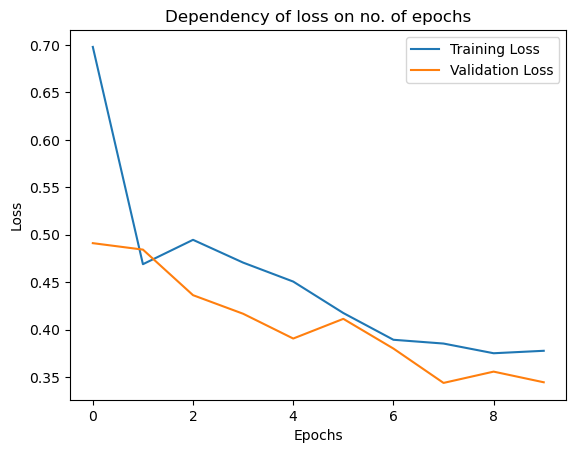

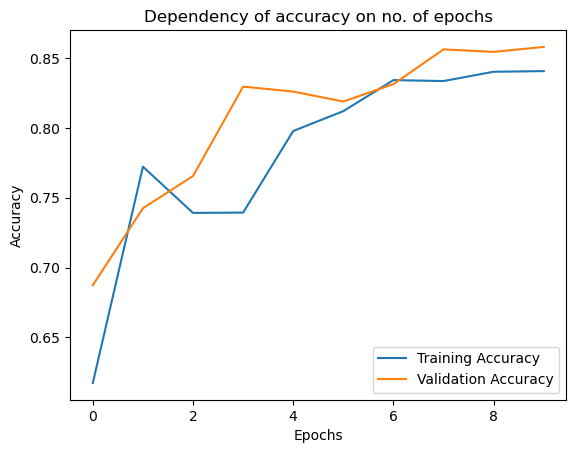

In [23]:
plot_curve(rnn_hist)